## โหลดรูปเบื้องต้น

In [1]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_transcript")
output_folder.mkdir(exist_ok=True)

def face_detection(gray_img):
    face_cascade = cv2.CascadeClassifier('experiment_and_research/files/haarcascade_frontalface_default.xml')

    #จำแนกใบหน้า
    scaleFactor = 1.1
    minNeighber = 12
    face_detect = face_cascade.detectMultiScale(gray_img, scaleFactor, minNeighber)

    expand_ratio = 0.6  # อัตราส่วนการขยาย (50% ของขนาดเดิม)
    for (x, y, w, h) in face_detect:
        # คำนวณขนาดขยาย
        x_exp = int(x - expand_ratio * w)
        y_exp = int(y - expand_ratio * h)
        w_exp = int(w + 2 * (expand_ratio) * w)
        h_exp = int(h + 2 * (expand_ratio+0.3) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(gray_img.shape[1] - x_exp, w_exp)
        h_exp = min(gray_img.shape[0] - y_exp, h_exp)

        # วาดกรอบ
        cv2.rectangle(gray_img, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (128, 128, 128), thickness=-1)
        cv2.imwrite("../data/output_images/output/face_remove.jpg", gray_img)

    return gray_img

# โหลดภาพ
#image = cv2.imread("../data/test_images/transcript/pun_20240817_0001.jpg")
#image = cv2.imread("../data/test_images/transcript/pun_f.jpg")
#image = cv2.imread("../data/test_images/transcript/pun_no_f.jpg")
#image = cv2.imread("../data/test_images/transcript/pun_tran_mo.jpg")
#image = cv2.imread("../data/test_images/word_images/test2.png")
#image = cv2.imread("../data/test_images/transcript/Transcript2.jpg")
#image = cv2.imread("../data/test_images/word_images/word_29.jpg")
image = cv2.imread("../data/test_images/transcript/img-3.png")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# จำกัด noise
denoised = cv2.bilateralFilter(image, 50, 100, 100)
cv2.imwrite(f"{output_folder}/transcript_denoised.png", denoised)

gray_img = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

# สำหรับภาพที่แสงสม่ำเสมอ
binary_mean = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=41, 
    C=20
)

# สำหรับภาพที่แสงไม่สม่ำเสมอ
binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=41, 
    C=20
)

# ใช้ Otsu Thresholding
_, binary_otsu = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

cv2.imwrite(f"{output_folder}/transcript.png", image)
cv2.imwrite(f"{output_folder}/transcript_gray.png", gray_img)
cv2.imwrite(f"{output_folder}/transcript_binary_g.png", binary_gaussian)
cv2.imwrite(f"{output_folder}/transcript_binary_m.png", binary_mean)
cv2.imwrite(f"{output_folder}/transcript_otsu.png", binary_otsu)

True

## แยกตารางกับข้อมูลส่วนบน

In [2]:
# แยกตาราง
original_img = image

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_gaussian, connectivity=8)

areas = [stat[4] for stat in stats]  # ดึงค่า area
sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
second_max_area = sorted_areas[1]  # ค่าอันดับ 2
second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม

table_position = stats[second_max_area_index]
x, y, w, h, area = table_position
table_img = binary_gaussian[y:y+h, x:x+w]
cv2.imwrite(f"{output_folder}/table.png", table_img)


# แยกประวัติส่วนตัว
upper_part = binary_gaussian[:y, :]
upper_part_color = original_img[:y, :]
cv2.imwrite(f"{output_folder}/upper_part_color.png", upper_part_color)


# หารูปโปรไฟล์
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(upper_part, connectivity=8)
areas = [stat[4] for stat in stats]  # ดึงค่า area
sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
second_max_area = sorted_areas[1]  # ค่าอันดับ 2
second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม

profile_position = stats[second_max_area_index]
x, y, w, h, area = profile_position
profile_img = upper_part[y:y+h, x:x+w]

# ประวัติส่วนตัวที่เอารูปโปรไฟล์ออก
personal_record = upper_part[:, :x-10]
cv2.imwrite(f"{output_folder}/personal_record.png", personal_record)

True

## จับกลุ่มข้อความใน record

In [3]:
def detect_text_group(dilalated_image, binary_image):

    text_group_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = char_stats[sorted_indices]

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00

    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats

        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        if w >= 90 and h >= 20:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            text_group_images.append(cca_img)
            cv2.imwrite(f"{output_folder}/personal_record/cca_{idx}.jpg", cca_img)
            cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return text_group_images

kernel = np.ones((6, 80), np.uint8)
lines_personal = cv2.dilate(personal_record, kernel, iterations=1)
cv2.imwrite(f"{output_folder}/personal_record/find_lines.png", lines_personal)

text_group_personal_images = detect_text_group(lines_personal, personal_record)

## แบ่งส่วนตาราง

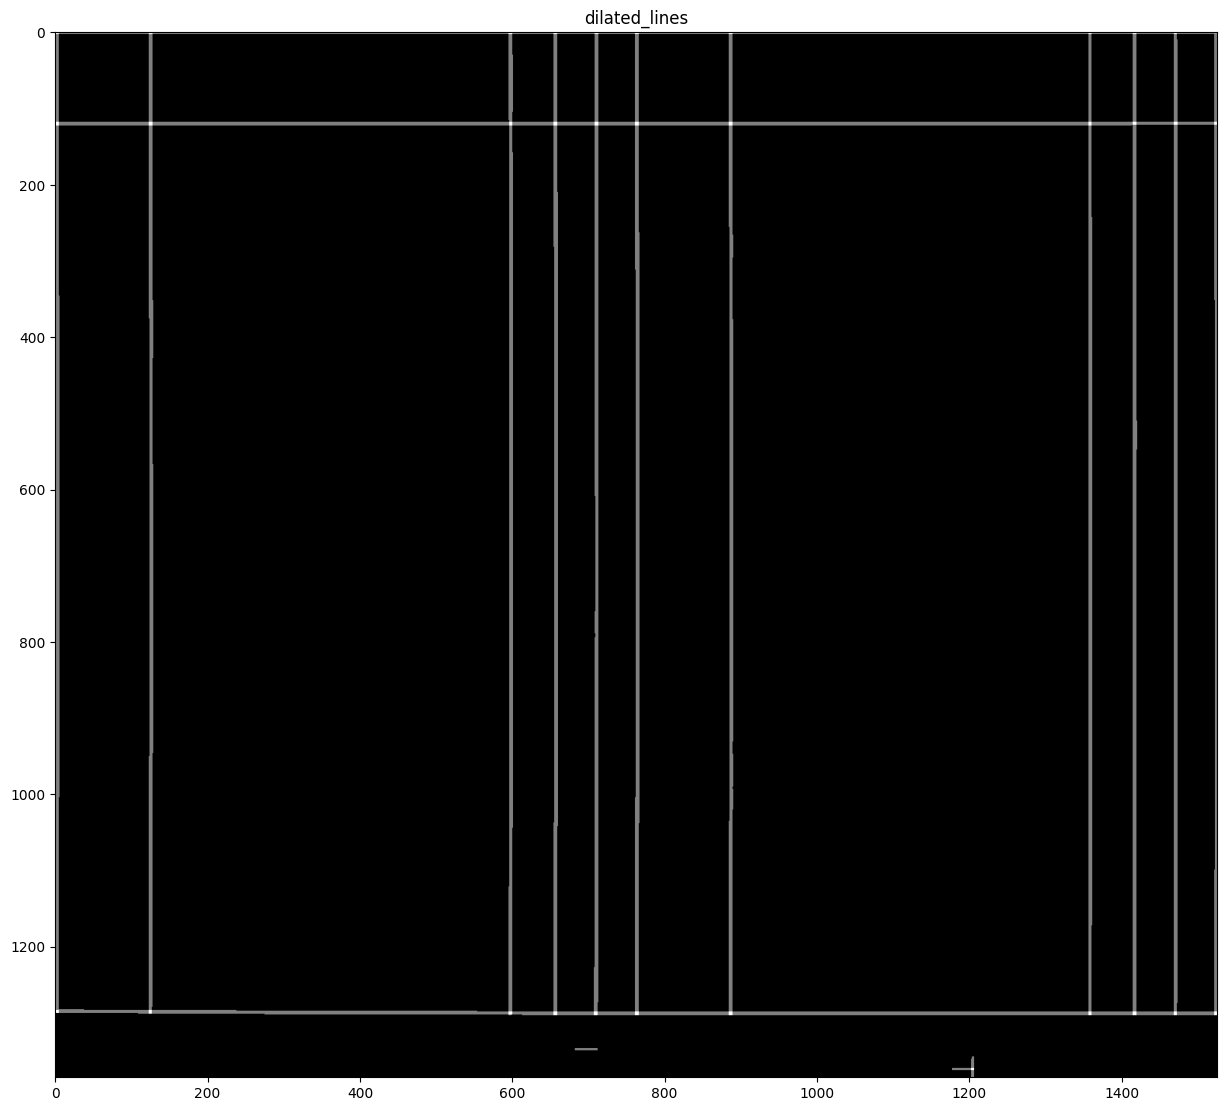

0
1
2
3
4
5
6
7
8
9


In [4]:
def table_cell_detection(table_img):
    # ใช้ Morphological Operations เพื่อตรวจจับเส้น
    #แนวนอน (Rows)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    horizontal_lines = cv2.morphologyEx(table_img, cv2.MORPH_OPEN, horizontal_kernel)

    #แนวตั้ง (Columns)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    vertical_lines = cv2.morphologyEx(table_img, cv2.MORPH_OPEN, vertical_kernel)

    # รวมเส้น
    table_structure = cv2.add(horizontal_lines, vertical_lines)

    
    # Combine lines
    combined_lines = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)

    # Dilate to connect broken lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_lines = cv2.dilate(combined_lines, kernel, iterations=1)

    plt.figure(figsize=(15, 15))
    plt.imshow(dilated_lines, cmap="gray")
    plt.title(f"dilated_lines")
    plt.show()


    # Find contours
    contours, _ = cv2.findContours(dilated_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return contours

table_cell_contours = table_cell_detection(table_img)

# ฟังก์ชันสำหรับดึงค่า y (แนวตั้ง) สำหรับการจัดเรียงตามแถว
def get_y_position(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return y

# ฟังก์ชันสำหรับดึงค่า x (แนวนอน) สำหรับการจัดเรียงตามคอลัมน์
def get_x_position(cell):
    x, y, w, h = cell
    return x

# จัดเรียง contours ตามตำแหน่ง y (แนวตั้ง) เพื่อแยกแถว
sorted_contours = sorted(table_cell_contours, key=get_y_position)

# แยกแถว
rows = []
current_row = []
previous_y = -1
for ctr in sorted_contours:
    x, y, w, h = cv2.boundingRect(ctr)
    if(w < 30 and h < 30):
        continue
    if previous_y == -1 or abs(y - previous_y) < 10:  # Same row threshold
        current_row.append((x, y, w, h))
    else:
        # จัดเรียงคอลัมน์ในแถวปัจจุบันตามตำแหน่ง x
        rows.append(sorted(current_row, key=get_x_position))
        current_row = [(x, y, w, h)]
    previous_y = y

# เพิ่มแถวสุดท้าย
if current_row:
    rows.append(sorted(current_row, key=get_x_position))

cell_images = []
for row_index, row in enumerate(rows[1:2]):
    for col_index, cell in enumerate(row):
        x, y, w, h = cell
        #cell_image = table_img[y:y+h, x:x+w]
        cell_img = table_img[y+4:y+h-4, x+4:x+w-4]

        # ตัดขอบออก 5%
        #margin_x = int(w * 0.05)  # คำนวณขอบ 2% ของความกว้าง
        #margin_y = int(h * 0.02)  # คำนวณขอบ 2% ของความสูง
        #cropped_cell_image = cell_image[margin_y:h-margin_y, margin_x:w-margin_x]

        cell_images.append(cell_img)
        print(col_index)
        cv2.imwrite(f"{output_folder}/table/Row_{row_index}_Col_{col_index}.png", cell_img)



### จับกลุ่มข้อความในตาราง

In [5]:
def detect_text_group_in_cell(dilalated_image, binary_image):
    rgb_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

    text_group_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 1])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = char_stats[sorted_indices]

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00

    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats
        #print("  area :", area)

        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        if area >= 100:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            text_group_images.append(cca_img)
            #cv2.imwrite(f"{output_folder}/table/cca_{idx}.jpg", cca_img)
            cv2.rectangle(rgb_image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)
    
    return text_group_images, rgb_image

cell_text_group_images = []
for idx, cell_img in enumerate(cell_images):
    kernel = np.ones((5, 15), np.uint8)
    lines_cell = cv2.dilate(cell_img, kernel, iterations=1)
    cv2.imwrite(f"{output_folder}/table/text_group/cell_{idx}.png", lines_cell)
    print("cell_img :", idx)
    text_group_cells, cca_img = detect_text_group_in_cell(lines_cell, cell_img)
    cv2.imwrite(f"{output_folder}/table/text_group/cca_{idx}.jpg", cca_img)
    cell_text_group_images.append(text_group_cells)

cell_img : 0
cell_img : 1
cell_img : 2
cell_img : 3
cell_img : 4
cell_img : 5
cell_img : 6
cell_img : 7
cell_img : 8
cell_img : 9


### จับข้อความย่อยในกลุ่มข้อความของ cell ตาราง

In [6]:
def detect_text_in_group(binary_image):
    kernel = np.ones((6, 6), np.uint8)
    dummy_image = cv2.dilate(binary_image, kernel, iterations=3)

    '''
    plt.figure(figsize=(5,5))
    plt.imshow(dummy_image, cmap="gray")
    plt.title(f"sub text")
    plt.show()
    '''

    sub_text_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = char_stats[sorted_indices]

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00
    #for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
    for idx, stats in enumerate(sorted_stats):
        #x, y, w, h, area = stats[i]
        x, y, w, h, area = stats
        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
        sub_text_images.append(cca_img)
        #cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
        #cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return sub_text_images 

cell_text_group_sub_images = []
for idx_cell, cell in enumerate(cell_text_group_images):
    #print("cell ที่ :", idx_cell+1)

    sub_text_cell_images = []
    for idx_text, text_img in enumerate(cell):
        #print("  ข้อความที่ :", idx_text+1)
        sub_text_cell_images.append(detect_text_in_group(text_img))

    cell_text_group_sub_images.append(sub_text_cell_images)



### จับตัวอักษร

In [7]:
def percentage_difference(value1, value2):
    return abs(value1 - value2) / value1 * 100

def sort_and_swap(stats):

    if(len(stats) > 1):
        """
        จัดเรียงข้อมูลใน stats โดยเรียงจาก y + h (มากไปน้อย)
        และตรวจสอบว่าข้อมูลที่มี area ใหญ่ที่สุดอยู่ในตำแหน่งแรกสุดหรือไม่
        """
        # คำนวณค่า y + h สำหรับการจัดเรียง
        stats_with_indices = [(i, stat) for i, stat in enumerate(stats)]
        stats_with_indices.sort(key=lambda x: x[1][1] + x[1][3], reverse=True)  # y + h (มาก -> น้อย)

        # สร้างลิสต์ใหม่หลังการจัดเรียง
        sorted_stats = [stat for _, stat in stats_with_indices]
        sorted_stats = np.array(sorted_stats)

        # หาค่า area ที่ใหญ่ที่สุดและตำแหน่ง
        areas = [stat[4] for stat in sorted_stats]  # ค่า area อยู่ใน index ที่ 4
        max_area = max(areas)
        max_area_index = areas.index(max_area)

        # กรองเอา noise ออกโดยเทียบกับ area ที่ใหญ่ที่สุด
        sorted_stats_noise_remove = []
        for stat in (sorted_stats):
            difference = percentage_difference(max_area, stat[4])
            #print("Max Area :", max_area)
            #print("Difference :", difference)
            if(difference < 93):
               sorted_stats_noise_remove.append(stat)
        sorted_stats = np.array(sorted_stats_noise_remove)
        
        # สร้างคอลัมน์ใหม่ที่มีค่าเริ่มต้นจาก 0 และเพิ่มทีละ 1
        rows = sorted_stats.shape[0]  # จำนวนแถว
        new_column = np.arange(rows).reshape(-1, 1)  # คอลัมน์ [0, 1, 2, ...]

        # เพิ่มคอลัมน์ใหม่เข้าไปใน array เดิม
        sorted_stats = np.hstack((sorted_stats, new_column))

        # หาค่า area ที่ใหญ่ที่สุดและตำแหน่ง
        areas = [stat[4] for stat in sorted_stats]  # ค่า area อยู่ใน index ที่ 4
        max_area = max(areas)
        max_area_index = areas.index(max_area)
    
        # ตรวจสอบว่า area ที่ใหญ่ที่สุดอยู่ตำแหน่งแรกหรือไม่
        if max_area_index != 0:
            # สลับตำแหน่งตัวที่มี area ใหญ่ที่สุดกับตัวแรก
            print("สลับตำแหน่ง")
            print("max_area : index", max_area_index)
            sorted_stats[[0, max_area_index]] = sorted_stats[[max_area_index, 0]]
            #sorted_stats[0], sorted_stats[max_area_index] = sorted_stats[max_area_index], sorted_stats[0]

        #ในกรณี "มีตัวเดียว"
        elif max_area_index == 0:
            print("มีตัวเดียว")
            sorted_stats[:, -1]+=1

        #ในกรณีสระ "อะ"
        if (len(sorted_stats) == 2):
            difference = percentage_difference(sorted_stats[0][4], sorted_stats[1][4])
            print(difference)
            if(difference <= 20):
                sorted_stats[0][-1] = 2
                sorted_stats[1][-1] = 2

        return sorted_stats
    else:
        new_values = [1]  # ต้องมีจำนวนเท่ากับจำนวนแถว

        # เพิ่มเลขในตำแหน่งสุดท้ายของทุกแถว
        new_values_column = np.array(new_values).reshape(-1, 1)  # แปลงเป็นคอลัมน์
        stats = np.hstack([stats, new_values_column])

        return stats
    
def char_level(char_image):
    debug = False  # ตั้งค่าเปิด/ปิด Debug

    kernel = np.ones((1, 1), np.uint8)
    #dummy_image = cv2.dilate(char_image, kernel, iterations=1)
    dummy_image = cv2.erode(char_image, kernel, iterations=1)

    #plt.figure(figsize=(1,1))
    #plt.imshow(dummy_image, cmap="gray")
    #plt.title(f"text")
    #plt.show()
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(char_image, connectivity=8)
    sorted_stats = sort_and_swap(stats[1:])
    char_level_group = []

    sum_area = 0
    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background

        x, y, w, h, area, level = stats

        sum_area += area

        # กรอง noise หรือส่วนที่ไม่ใช่ข้อความ
        if w <= 2 and h <= 2:  # ปรับค่าตามความเหมาะสม
            print("เล็กเกินข้าม")
            #print(area)
            continue

        cca_img = char_image[y:y+h, x:x+w]
        char_level_group.append([cca_img, level])
        #cv2.imwrite(f"../data/test_images/char_level/cca_{idx}.jpg", cca_img)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.imwrite(f"../data/test_images/char_level/dummy_image.jpg", dummy_image)
        
        if debug:
            plt.figure(figsize=(1,1))
            plt.imshow(cca_img, cmap="gray")
            plt.title(f"text")
            plt.show()
            print("area :" ,area)
            print("level:", level)

    #print(f"Sum fo area: {sum_area}")
    #print(f"Number of characters detected: {len(char_level_group)}")
    return char_level_group 

def detect_char(binary_image):
    rgb_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
    debug = False  # ตั้งค่าเปิด/ปิด Debug

    kernel = np.ones((1, 1), np.uint8)
    kernel_2 = np.ones((5, 1), np.uint8)
    kernel_3 = np.ones((2, 1), np.uint8)

    #dummy_image = cv2.erode(binary_image, kernel, iterations=1)
    dummy_image = cv2.dilate(binary_image, kernel_2, iterations=1)

    # การทำ Opening
    #opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_3, iterations=1)
    #dummy_image = cv2.dilate(opened, kernel_2, iterations=1)

    '''
    plt.figure(figsize=(3, 3))
    plt.imshow(binary_image, cmap="gray")
    plt.imshow(dummy_image, cmap="gray")
    plt.title(f"dummy_image")
    plt.show()
    '''
    

    char_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

    # กรองข้อมูล Background และจัดเรียงจากซ้ายไปขวา (ตามค่า x)
    char_stats = stats[1:]  # ข้าม Background (index 0)
    sorted_indices = np.argsort(char_stats[:, 0])  # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = char_stats[sorted_indices]

    for idx, stat in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stat
        #print("area : ",area)

        # ตัดภาพใน Bounding Box
        cca_img = binary_image[y:y+h, x:x+w]
        #cca_img = binary_image[:, x:x+w]

        if debug:
            plt.figure(figsize=(1, 1))
            plt.imshow(cca_img, cmap="gray")
            plt.title(f"Character {idx}")
            plt.show()

        # ใช้ฟังก์ชัน char_level เพื่อแยกตัวอักษรย่อย
        char_leveled = char_level(cca_img)

        # รวมตัวอักษรย่อยในรายการ
        char_images.extend(char_leveled)
        #cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
        #cv2.rectangle(rgb_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

    #plt.figure(figsize=(5, 5))
    #plt.imshow(rgb_image, cmap="gray")
    #plt.show()

    return char_images

text_group_sub_char_cell_images = []

for idx_cell, cell in enumerate(cell_text_group_sub_images):
    print("cell ที่ :", idx_cell+1)

    sub_text_cell = []
    for idx_group, text_group in enumerate(cell):
        print("  กลุ่มข้อความที่ :", idx_group+1)

        char_in_sub_text = []
        for idx_sub, sub_text in enumerate(text_group):
            print("    ข้อความย่อยที่ :", idx_sub+1)
            char_images = detect_char(sub_text)
            print("        จำนวนตัวอักษร",len(char_images))
            char_in_sub_text.append(char_images)

        sub_text_cell.append(char_in_sub_text)
    text_group_sub_char_cell_images.append(sub_text_cell)

        

            
    


cell ที่ : 1
  กลุ่มข้อความที่ : 1
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 2
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 3
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 4
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 5
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 6
    ข้อความย่อยที่ : 1
สลับตำแหน่ง
max_area : index 1
90.0
เล็กเกินข้าม
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 7
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 8
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 9
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 10
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 11
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10
  กลุ่มข้อความที่ : 12
    ข้อความย่อยที่ : 1
เล็กเกินข้าม
เล็กเกินข้าม
        จำนวนตัวอักษร 9
  กลุ่มข้อความที่ : 13
    ข้อความย่อยที่ : 1
        จำนวนตัวอักษร 10

## Predict images with Multiple models 

### table

In [8]:
from tensorflow.keras.models import load_model

model_path = "../models/thai_and_numerals_model.h5"
model = load_model(model_path)

model_path_char_level_0 = "../models/char_level_0_model.h5"
model_path_char_level_1 = "../models/char_level_1_model.h5"
model_path_char_level_2 = "../models/char_level_2_model.h5"
model_path_char_level_3 = "../models/char_level_3_model.h5"

model_char_level_0 = load_model(model_path_char_level_0)
model_char_level_1 = load_model(model_path_char_level_1)
model_char_level_2 = load_model(model_path_char_level_2)
model_char_level_3 = load_model(model_path_char_level_3)

# สร้าง Mapping ของโมเดลตามระดับ
models = {
    0: model_char_level_0,
    1: model_char_level_1,
    2: model_char_level_2,
    3: model_char_level_3,
}

In [10]:
#print(len(text_group_sub_char_cell_images))

cell_subject_code = text_group_sub_char_cell_images[0]
cell_subject_name = text_group_sub_char_cell_images[1]
cell_credit = text_group_sub_char_cell_images[2]
cell_academic_results = text_group_sub_char_cell_images[3]

for idx_group, text_group in enumerate(cell_subject_name):
    print("กลุ่มข้อความ : ",idx_group+1)
    for idx_sub, sub_text in enumerate(text_group):
        print("     ข้อความย่อยที่ :", idx_sub+1)
        for idx_char, char_img in enumerate(sub_text):
            #plt.figure(figsize=(1, 1))
            #plt.imshow(char_img[0], cmap="gray")
            #plt.title(f"Character {idx_char}")
            #plt.show()
            #print("       จำนวนตัวอักษร :", len(char_img))
            #print(char_img[0])
            print("          level : ",char_img[1])
            #print("     ตัวอัก :", idx_sub+1)



กลุ่มข้อความ :  1
     ข้อความย่อยที่ : 1
          level :  1
          level :  2
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  2
          level :  1
          level :  1
          level :  1
          level :  2
          level :  3
          level :  1
กลุ่มข้อความ :  2
     ข้อความย่อยที่ : 1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  0
          level :  1
          level :  2
          level :  1
          level :  1
กลุ่มข้อความ :  3
     ข้อความย่อยที่ : 1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          level :  1
          lev

In [11]:
def Rule_Based_Post_Processing(word):

    if not word:
        return word
    
    word = word.replace("ัั", "ะ")
    word = word.replace("เเ", "แ")

    return word

char_level_2_label = [
     'ิ', 'ี', 'ึ', 'ื', '็', 'ั', 'ํ', '่', '้', '๊', '๋',
]

print(char_level_2_label)


['ิ', 'ี', 'ึ', 'ื', '็', 'ั', 'ํ', '่', '้', '๊', '๋']


In [13]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt
from matplotlib import rc

thai_and_numerails_special_characters = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',

    'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 
    'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 
    'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 
    'ห', 'ฬ', 'อ', 'ฮ',

    'ะ', 'า', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'โ', 'ฤ', 'ใ', 'ไ', '็', 
    'ั', 'ํ',

    '่', '้', '๊', '๋',

    '+', '-', '*', '(', ')', '.', '=', '/', '|'
]

char_level_0_label = [
    'ุ', 'ู'
]

char_level_1_label = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',

    'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 
    'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 
    'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 
    'ห', 'ฬ', 'อ', 'ฮ',

    'า', 'เ', 'โ', 'ฤ', 'ใ', 'ไ',

    '+', '-', '*', '(', ')', '.', '=', '/', '|'
]

char_level_2_label = [
     'ิ', 'ี', 'ึ', 'ื', '็', 'ั', 'ํ', '่', '้', '๊', '๋',
]

char_level_3_label = [
    '่', '้', '๊', '๋',
]

char_level_labels = {
    0: char_level_0_label,
    1: char_level_1_label,
    2: char_level_2_label,
    3: char_level_3_label,
}

def resize_with_min_padding(image, desired_size, min_padding):
    
    """
    ปรับขนาดภาพให้ใกล้เคียง desired_size โดยลด Padding และเพิ่มการขยายภาพต้นฉบับ
    """
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a valid numpy array.")

    if not isinstance(desired_size, int) or desired_size <= 0:
        raise ValueError("desired_size must be a positive integer.")

    old_size = image.shape[:2]  # (height, width)
    max_size = max(old_size)

    # คำนวณอัตราส่วนการปรับขนาดให้ใกล้เคียง desired_size
    ratio = float(desired_size - 2 * min_padding) / max_size
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม แต่ใหญ่ขึ้น
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding ใหม่
    delta_w = max(desired_size - new_size[1], 0)  # Padding ด้านความกว้าง
    delta_h = max(desired_size - new_size[0], 0)  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # ตรวจสอบสีสำหรับ Grayscale หรือ RGB
    color = [0] if len(image.shape) == 2 else [0, 0, 0]

    # เพิ่ม Padding รอบภาพ
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image


# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก text_char_group_images
processed_images = []
char_levels = []

text_block = []
for idx_text_group, text_group in enumerate(cell_academic_results):
    #print("กลุ่มข้อความ", idx_text_group+1)

    text_result = ""
    for idx_text_sub, text_sub in enumerate(text_group):
        #print("  ข้อความย่อยในกลุ่มข้อความ", idx_text_sub+1)

        sub_text_result = ""
        for idx_char, char in enumerate(text_sub):
            char_image, char_level = char
            if char is None:
                print(f"Character image {idx_char} is None.")
                continue  # ข้ามภาพนี้
            else:
                #plt.figure(figsize=(1,1))
                #plt.imshow(char_img, cmap="gray")

                # เพิ่ม Padding และปรับขนาดภาพ
                padded_img = resize_with_min_padding(char_image, input_size, min_padding=1)

                # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
                normalized_img = padded_img / 255.0

                # เพิ่มช่องทางสี (Channel) สำหรับโมเดลที่รองรับ Input แบบ (Height, Width, Channels)
                if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                    normalized_img = np.expand_dims(normalized_img, axis=-1)

                    processed_image = np.expand_dims(normalized_img, axis=0)  # เพิ่ม Batch Dimension

                    if char_level in models:
                        prediction = models[char_level].predict(processed_image)
                        predicted_class = np.argmax(prediction)
                        confidence_score = np.max(prediction)

                        class_level = char_level_labels[char_level]
                        predicted_letter = class_level[predicted_class]
                    else:
                        print("level ไม่ตรง")
                        prediction = models[2].predict(processed_image)
                        predicted_class = np.argmax(prediction)
                        confidence_score = np.max(prediction)

                        class_level = char_level_labels[2]
                        predicted_letter = class_level[predicted_class]

                    # แปลงคลาสเป็นตัวอักษร
                    #print("Char Level :", char_level)
                    #print("Predicted Class :", predicted_class)
                    #class_level = char_level_labels[char_level]
                    #predicted_letter = class_level[predicted_class]

                    #print(predicted_letter)

                    sub_text_result += predicted_letter


        text_result += sub_text_result
        text_result_post = Rule_Based_Post_Processing(text_result)
        text_result_post += " "
    text_block.append(text_result_post)

# แสดงผลลัพธ์ข้อความ
for idx_text, text in enumerate(text_block):
    print(f"text {idx_text + 1}: {text}")



1/1 [==============================] - 0s 16ms/step
text 1: 4ต0 
text 2: ผห 
text 3: ผป 
text 4: ผ 
text 5: ผฒ 
text 6: ผ+ 
text 7: ผ+ 
text 8: ผฒ 
text 9: ผต 
text 10: ผ+ 
text 11: ผ+ 
text 12: 4ห0 
text 13: 4ฑ0 
text 14: 4+0 
text 15: 4ต0 
text 16: 4ฟ0 
text 17: 4ต0 
text 18: 4+0 
text 19: 4ต0 
text 20: ผ 
text 21: 3+5 
text 22: 4ญ0 
text 23: 4+0 
text 24: ผ+ 


In [40]:
from pythainlp.spell import correct
from pythainlp.tokenize import word_tokenize
text = "การเขียนแบบอิเล็กทรอนิกส่ด้วยคอมพิวเตอร่"
#corrected_text = correct(text)
#print(corrected_text)  # ผลลัพธ์: ฉันชอบกีฬาและท่องเที่ยว

words = word_tokenize(text)
print("ตัดคำ:", words)

# แก้คำผิด
corrected_words = [correct(word) for word in words]
print("แก้คำผิด:", corrected_words)

ตัดคำ: ['การ', 'เขียนแบบ', 'อิ', 'เล็ก', 'ทรอ', 'นิ', 'กส่', 'ด้วย', 'คอม', 'พิว', 'เต', 'อร่']
แก้คำผิด: ['การ', 'เขียนแบบ', 'อิ', 'เล็ก', 'ทรอ', 'นิ', 'ใส่', 'ด้วย', 'คอม', 'พิว', 'เต', 'ไร่']
